In [1]:
import matplotlib.pyplot as plt
import proplot as pplt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(123)

import math
import time
import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,PowerTransformer, StandardScaler
from sklearn import preprocessing #数据标准化处理


from tensorflow.keras.models import Sequential #序贯式模型 
from tensorflow.keras.layers import Dense, Dropout, Layer, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib
from tensorflow.keras.models import load_model


import mdn

from scipy.stats import pearsonr

m_e = 5.9722e24 # Earth mass
r_e = 6.371e6 # Earth radius

from numpy.random import seed
seed(123)
import tensorflow as tf
tf.random.set_seed(123)



#推送通知
import telegram
def sendmessage(datas):
    # 你的机器人token
    bot = telegram.Bot(token='5595067386:AAFJR0A1CiCvr2Y95uj4iRm2XYbUDCjg3gw')
    # 不加ensure_ascii=False 结果会是ASCII编码，我们需要用中文正常显示
#     textMsg = json.dumps(datas, ensure_ascii=False)
    # 修改群ID和机器人
    bot.send_message(chat_id='762394206', text=datas, parse_mode='markdownV2')

C:\Users\zy\anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [2]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #有多个GPU时可以指定只使用第几号GPU
config =tf.compat.v1.ConfigProto()
config.allow_soft_placement=True #允许动态放置张量和操作符
config.gpu_options.per_process_gpu_memory_fraction = 0.9 #最多使用90%GPU内存
config.gpu_options.allow_growth=True   #初始化时不全部占满GPU显存, 按需分配 
sess = tf.compat.v1.Session(config = config)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
# set figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7.2, 5.4

# calculagraph
def helper_print_with_time(*arg,sep=','):
    print(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime()),sep.join(map(str,arg)))

In [4]:
# merge nowater data
nowater_data_frames = []
for i in range(1, 11):
    file_path = f'nowater100_{i}.dat'
    df = pd.read_table(file_path, delimiter="\s+", header=None, )
    nowater_data_frames.append(df)
df_nowater = pd.concat(nowater_data_frames)

# merge water data
water_data_frames = []
for i in range(1, 11):
    file_path = f'water1000_{i}.dat'
    df = pd.read_table(file_path, delimiter="\s+", header=None, )
    water_data_frames.append(df)
df_water = pd.concat(water_data_frames)

# combine merged nowater and water data
df_all = pd.concat([df_nowater,df_water])

# rename columns
df_all.columns = ['Mass', 'Radius', 'WMF', 
                  'CMF', 'WRF', 'CRF', 'PRS_WMB', 
                  'TEP_WMB', 'PRS_CMB', 'TEP_CMB', 'PRS_CEN', 'TEP_CEN', 
                  'k2', 'FeMg_mantle', 'SiMg_mantle', 'FeO_mantle']

# reset index
df_all = df_all.reset_index(drop=True)

df_all = df_all.astype(float)


############################################################
################### calculate bulk Fe/Mg ###################
############################################################
CaMg       = 0.06
AlMg       = 0.08
wt_frac_S_core = 0.0695 #by mass

mFe = 55.845
mMg = 24.306
mSi = 28.0867
mO = 15.9994
mS = 32.0650
mCa = 40.078
mAl = 26.981

## you can check the FeO_mantle results from the mantle molar ratios FeMg, SiMg, CaMg, AlMg
# The results should be same as the column FeO_mantle
reduced_mantle_mass = df_all['FeMg_mantle'] * (mFe+mO) + df_all['SiMg_mantle'] * (mSi+2.0*mO) + CaMg * (mCa+mO) + AlMg * (mAl+1.5*mO) + (mMg+mO)
FeO_mantle_cal = df_all['FeMg_mantle'] * (mFe+mO) / reduced_mantle_mass

# number of Fe atoms in the core
nFe_core = df_all['CMF'] * (1.0 - wt_frac_S_core) / mFe

# number of Fe atoms in the mantle
nFe_mantle = (1.0 - df_all['CMF'] - df_all['WMF']) * df_all['FeO_mantle'] / (mFe + mO)

# number of Mg atoms in the mantle 
nMg_mantle = nFe_mantle / df_all['FeMg_mantle']

# bulk FeMg 
FeMg = (nFe_core + nFe_mantle) / nMg_mantle
df_all['FeMg'] = FeMg

# bulk SiMg: there is no Si & Mg in the core
df_all['SiMg'] = df_all['SiMg_mantle']

df_all = df_all[df_all['FeMg']<=40]

df_all["Fe_(Mg+Si)"] = df_all["FeMg"]/(df_all["SiMg"] + 1)

df_all["MRF"] = 1 - df_all["WRF"] - df_all["CRF"]

In [5]:
df_all.describe()

,Mass,Radius,WMF,CMF,WRF,CRF,PRS_WMB,TEP_WMB,PRS_CMB,TEP_CMB,PRS_CEN,TEP_CEN,k2,FeMg_mantle,SiMg_mantle,FeO_mantle,FeMg,SiMg,Fe_(Mg+Si),MRF
count,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06,4.357089e+06
mean,4.419622e+00,1.371397e+00,3.915372e-02,4.237744e-01,5.663790e-02,5.638108e-01,1.967278e+01,5.045740e+02,5.672068e+02,3.287397e+03,1.859303e+00,5.050859e+03,7.794056e-01,6.656742e-01,7.846859e-01,3.207855e-01,4.577265e+00,7.846859e-01,2.605411e+00,3.795513e-01
std,2.750439e+00,3.008267e-01,2.936203e-02,2.555677e-01,3.756937e-02,1.805099e-01,1.990742e+01,3.492667e+02,4.532993e+02,8.363256e+02,1.284444e+00,1.158169e+03,1.194250e-01,3.363541e-01,3.492888e-01,1.278237e-01,5.613731e+00,3.492888e-01,3.199335e+00,1.856428e-01
min,1.000030e-01,4.295720e-01,0.000000e+00,3.343070e-07,0.000000e+00,5.074670e-03,1.000000e-04,3.000000e+02,3.739640e+00,1.657680e+03,2.263520e-02,1.835810e+03,5.307430e-01,1.111110e-01,4.166670e-01,5.121270e-02,1.111134e-01,4.166670e-01,4.169308e-02,2.653500e-02
25%,2.061480e+00,1.178080e+00,1.327900e-02,2.013240e-01,2.544570e-02,4.337820e-01,4.399750e+00,3.811230e+02,2.007560e+02,2.617540e+03,7.996060e-01,4.260080e+03,6.886360e-01,3.888890e-01,5.000000e-01,2.192050e-01,1.285580e+00,5.000000e-01,7.374106e-01,2.300960e-01
50%,4.116350e+00,1.416680e+00,3.529290e-02,4.124430e-01,5.575140e-02,5.755330e-01,1.415380e+01,3.921080e+02,4.429690e+02,3.253340e+03,1.622400e+00,5.055110e+03,7.611660e-01,6.666670e-01,6.666670e-01,3.363660e-01,2.437219e+00,6.666670e-01,1.398577e+00,3.683930e-01
75%,6.621290e+00,1.599910e+00,6.243100e-02,6.410940e-01,8.606800e-02,7.085780e-01,2.903750e+01,4.158480e+02,8.357850e+02,3.914040e+03,2.706530e+00,5.838060e+03,8.518520e-01,9.444440e-01,1.000000e+00,4.255480e-01,5.388855e+00,1.000000e+00,3.071244e+00,5.135304e-01
max,1.000000e+01,2.060750e+00,1.000000e-01,9.000000e-01,1.631830e-01,9.371470e-01,1.619600e+02,1.600000e+03,2.443090e+03,5.856440e+03,5.670400e+00,8.945950e+03,1.387210e+00,1.222220e+00,1.666670e+00,5.467820e-01,3.999975e+01,1.666670e+00,2.823511e+01,9.904327e-01


In [6]:
input_parameters = [
    'Mass', 
    'Radius',
    'Fe_(Mg+Si)',
    'k2',
]


output_parameters = [
    'WRF',
    'MRF',
    'CRF',
#     'WMF',
    'CMF', 
    'PRS_CMB',
    'TEP_CMB',
]

X = df_all[input_parameters]

y = df_all.loc[:, output_parameters]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

scaler_x = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train)
import joblib
joblib.dump(scaler_x, "MDN_MRCk2_Xscaler_20230524.save") 
joblib.dump(scaler_y, "MDN_MRCk2_yscaler_20230524.save")
# from pickle import dump
# save the scaler
# dump(scaler, open('scaler.pkl', 'wb'))
X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

a, X_test_scaled_pre, b, y_test_pre = train_test_split(X_test_scaled, y_test, test_size=0.2)

In [7]:
len(y_test)


435709

In [8]:
len(y_test_pre)

87142

# Train model

## 4-(512, 512, 512)-6
### N_HIDDEN=512
### testing data=0.1
### validation_split=0.1
### dropout=0.05 
### batchsize=256


In [9]:
DROPOUT = 0.05
N_HIDDEN, N_MIXES = 512, 20  # N_MIXES is the number of mixtures
INPUT_DIMS = len(input_parameters)              
OUTPUT_DIMS = len(output_parameters)
ACT_FUN = 'relu'
my_callbacks = [
    EarlyStopping(
        monitor='val_loss',
#         min_delta=0.0005,
        mode='min',
        patience=30, 
        verbose=0,
    ),
#     ModelCheckpoint(
#         filepath='model.{epoch:02d}-{val_loss:.2f}.h5', 
#         monitor='val_loss',
#         save_best_only=True,
# #         save_freq=5,
#     ),
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model = keras.Sequential()
model.add(Dense(N_HIDDEN, input_dim=INPUT_DIMS))
# model.add(BatchNormalization())
model.add(Activation(ACT_FUN))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
# model.add(BatchNormalization())
model.add(Activation(ACT_FUN))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
# model.add(BatchNormalization())
model.add(Activation(ACT_FUN))
model.add(Dropout(DROPOUT))
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES, name='mdn_outputs'))
model.summary()


helper_print_with_time('>>>begin')
sendmessage("*Start Training*" + "\u2757\ufe0f")
model.compile(
    loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES),
    optimizer=keras.optimizers.Adam(lr=0.0001)
)
history=model.fit(
    X_train_scaled,y_train_scaled,
    epochs=200,
    batch_size=512,
#     validation_data=(X_valid_scaled, y_valid_scaled),
    validation_split=0.1,
    # shuffle=True,
    # callbacks=[early_stopping],
    callbacks=my_callbacks,
    verbose=0)
helper_print_with_time('>>>end')
sendmessage("*Training Finished*" + "\u2705")
#serverjiang_send_server('Training Finished','from jupyter')
#

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2560      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2

C:\Users\zy\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\zy\anaconda3\lib\site-packages\proplot\internals\process.py:84: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  np.issubdtype(array.dtype, np.str)
C:\Users\zy\anaconda3\lib\site-packages\proplot\internals\process.py:85: FutureWarning: Conversion of the second argument of issubdtype f

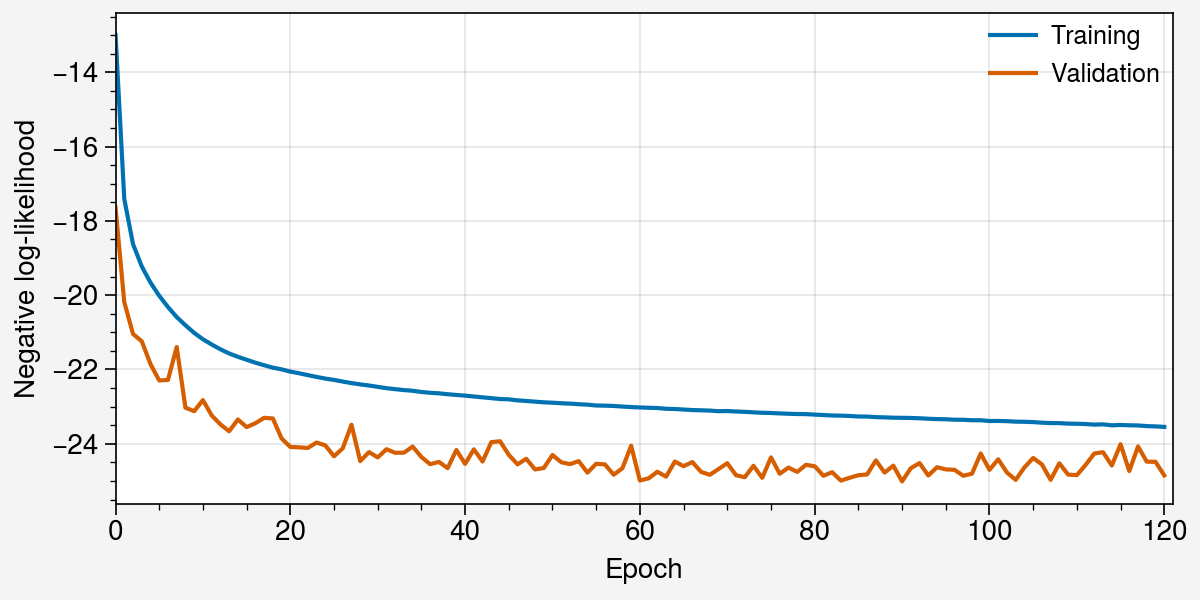

In [10]:

df_loss = pd.DataFrame(data=history.history)
df_loss.columns=['Training', 'Validation']
df_loss.to_excel("loss_MRCk2_20230524.xls")
fig = pplt.figure(figsize=(6,3))
ax = fig.subplot(xlabel='Epoch', ylabel='Negative log-likelihood')
ax.plot(df_loss, legend='ur', legend_kw={'frame':False, 'fontsize':20, 'ncol':1})
ax.format(xlim=(0,len(df_loss.index)), labelsize=10, ticklabelsize=10)
fig.save('MDN_MRCk2_loss_20230524.pdf')

In [11]:
model.save("MDN_MRCk2_20230524.h5")
# Save scaler
# import joblib
# joblib.dump(scaler_x, "MDN_MRk2_scaler_0810.save") 
# joblib.dump(scaler_y, "MDN_MRk2_scaler_0810.save")

In [12]:
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "MDN_MRCk2_20230505.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)

C:\Users\zy\anaconda3\lib\site-packages\proplot\internals\process.py:84: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  np.issubdtype(array.dtype, np.str)
C:\Users\zy\anaconda3\lib\site-packages\proplot\internals\process.py:85: FutureWarning: Conversion of the second argument of issubdtype from `object` to `np.generic` is deprecated. In future, it will be treated as `np.object_ == np.dtype(object).type`.
  or np.issubdtype(array.dtype, np.object)
C:\Users\zy\anaconda3\lib\site-packages\proplot\internals\process.py:84: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  np.issubdtype(array.dtype, np.str)
C:\Users\zy\anaconda3\lib\site-packages\proplot\internals\process.py:85: FutureWarning: Conversion of the second argument of issubdtype from `object` to `np

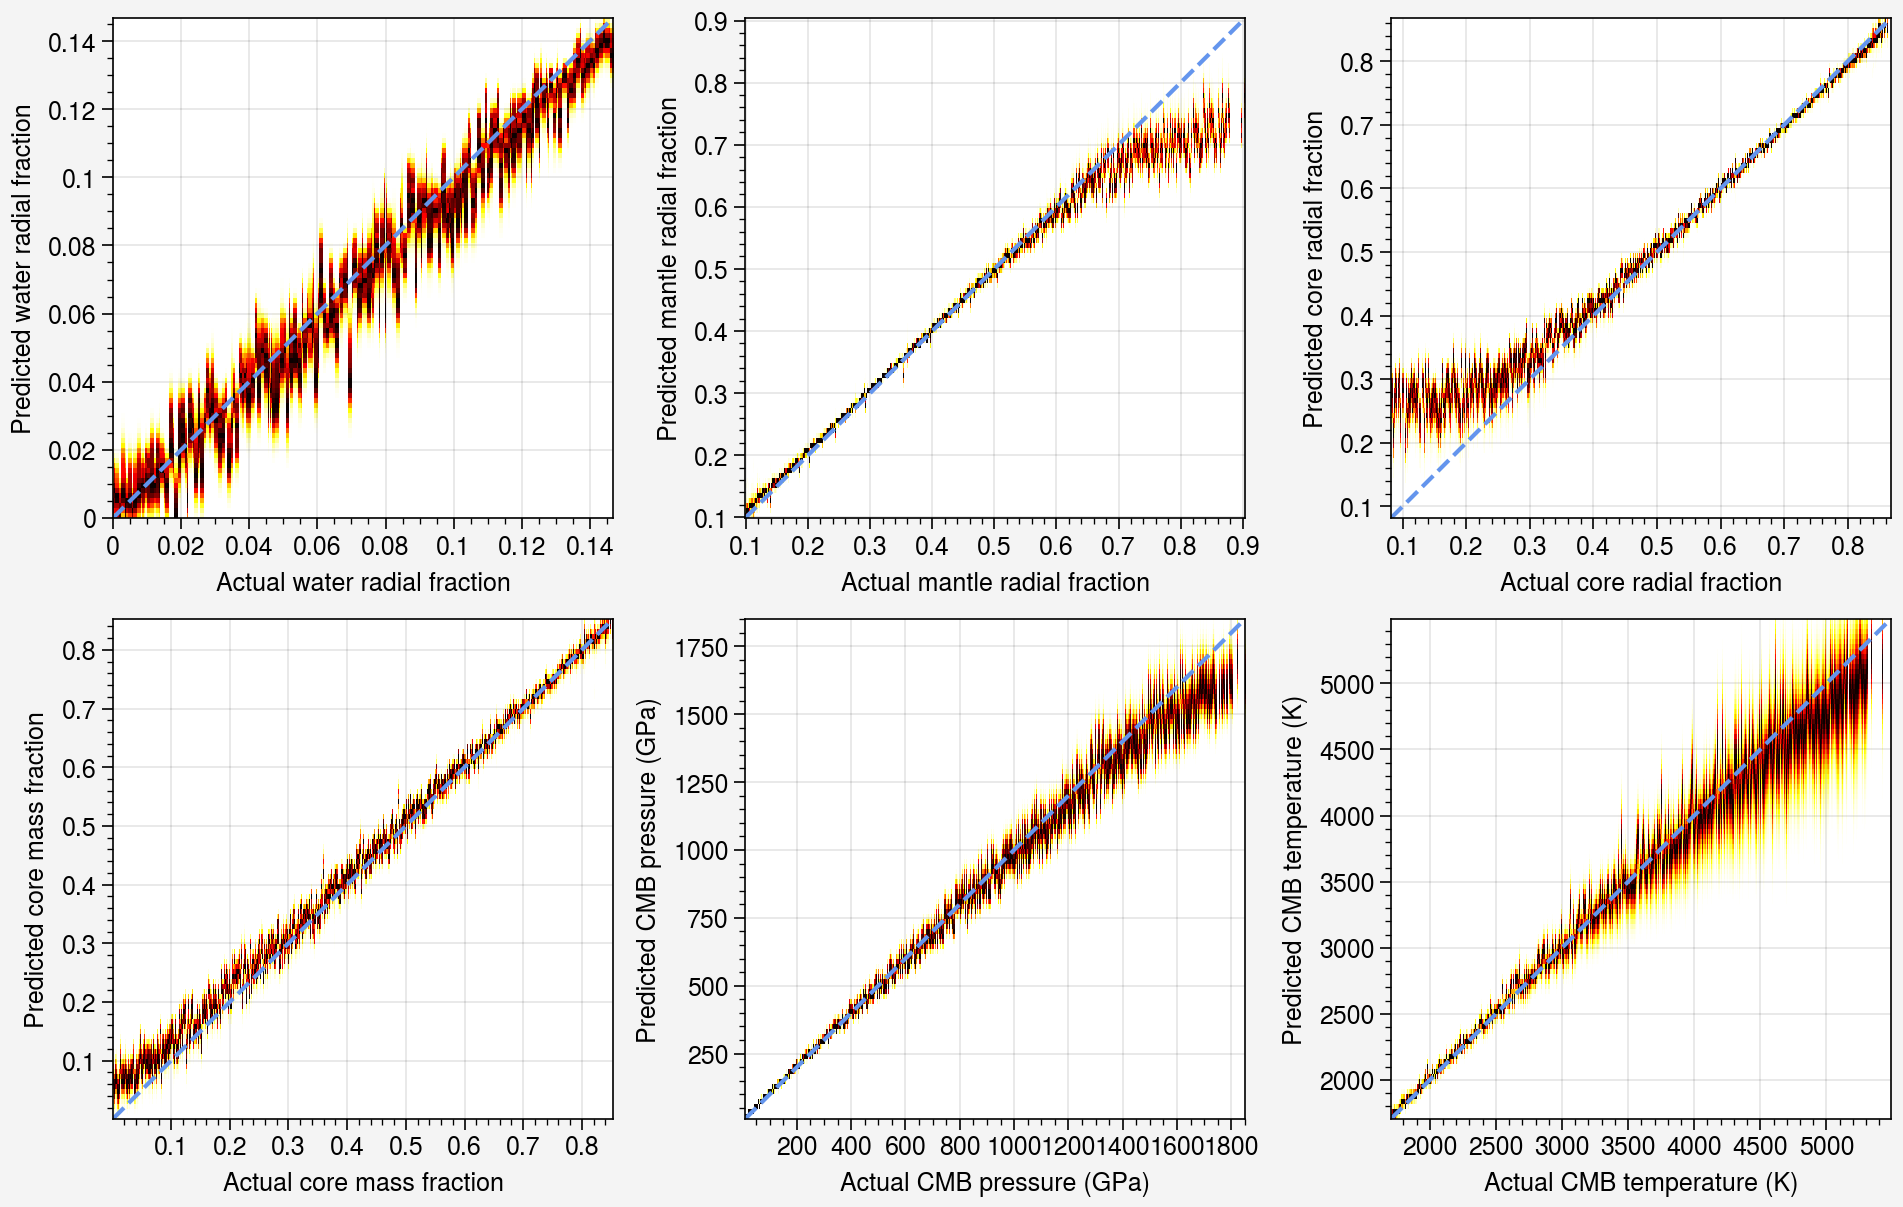

In [13]:
pred = model.predict(X_test_scaled_pre)
# pred contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

y_label = np.arange(0,1,0.01).reshape(-1,1)
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig, axs = pplt.subplots(
    nrows=2, ncols=3,
    share=False, 
#     tight=True,
)
xlabels = [
    "Actual water radial fraction","Actual mantle radial fraction", "Actual core radial fraction", 
    "Actual core mass fraction", "Actual CMB pressure (GPa)", "Actual CMB temperature (K)"
]
ylabels = [
    "Predicted water radial fraction","Predicted mantle radial fraction", "Predicted core radial fraction", 
    "Predicted core mass fraction", "Predicted CMB pressure (GPa)", "Predicted CMB temperature (K)"
]

xlocators = [
    0.02, 0.1, 0.1, 0.1, 200, 500
]
xminorlocators = [
    0.005, 0.02, 0.02, 0.02, 50, 100
]
sendmessage('start plotting')

for img_num in range(OUTPUT_DIMS):
    y_max = max(y_test_pre[output_parameters[img_num]])
    y_min = min(y_test_pre[output_parameters[img_num]])
    for c in range(len(y_test_pre)):
        for m in range(OUTPUT_DIMS):
            locals()['mus'+str(m)] = []
            locals()['sigs'+str(m)] = []
            for n in range(N_MIXES):
                locals()['mus'+str(m)].append(mus[c][n*OUTPUT_DIMS + m])
                locals()['sigs'+str(m)].append(sigs[c][n*OUTPUT_DIMS + m])
        i = img_num
        mus_ = np.array(locals()['mus'+str(i)])
        sigs_ = np.array(locals()['sigs'+str(i)])
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
        MM = MinMaxScaler()
        GMM_PDF_scaled = MM.fit_transform(GMM_PDF.reshape(-1, 1))
        tx, ty = [y_test_pre.values[c,i],y_min]
        axs[img_num].imshow(
            GMM_PDF_scaled.reshape(-1, 1),
            cmap=cmap, 
            norm=norm, 
            origin='lower', 
            extent=(tx, tx + 0.001, ty, y_max)
        )
    axs[img_num].plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    axs[img_num].format(
        xlim=(y_min, y_max), ylim=(y_min, y_max), 
        xlabel=xlabels[img_num], ylabel=ylabels[img_num],
        xlocator=xlocators[img_num], xminorlocator=xminorlocators[img_num]
    )
fig.save('prediction_MRCk2_20230503.pdf')
sendmessage('Drawing is complete')